In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# Chapter 5 — Decision Trees and Variants
## Lesson 7: Split Criteria (Gini, Entropy, Gain Ratio, Variance Reduction)

Decision trees are built by repeatedly choosing a split that makes the child nodes "purer" than the parent node.
This lesson focuses on *how* we quantify "purity" (or, for regression, "homogeneity") and how different split criteria
change the tree you get.

### Learning goals
By the end of this lesson you will be able to:

- Define and compute **Gini impurity**, **entropy**, **information gain**, and **gain ratio** for classification.
- Define and compute **variance reduction** (a.k.a. reduction in squared error) for regression trees.
- Implement these criteria from scratch and verify them against `scikit-learn`.
- Recognize practical failure modes: high-cardinality features, imbalance, small leaves, and noisy labels.

### Notation (used throughout)
Assume a node contains a dataset $S = \{(x_i, y_i)\}_{i=1}^n$.

- For **classification**, $y_i \in \{1,\dots,K\}$ and $p_k$ is the fraction of samples in class $k$ inside the node.
- For **regression**, $y_i \in \mathbb{R}$ and $\bar y$ is the average target in the node.
- A split partitions $S$ into children $S_1,\dots,S_m$ (binary splits have $m=2$).

We always measure the *weighted* post-split impurity:
$$
I_{\text{after}} = \sum_{j=1}^m \frac{|S_j|}{|S|} I(S_j),
$$
and the improvement is
$$
\Delta I = I(S) - I_{\text{after}}.
$$

## 3) Practice: implement criteria + verify with real datasets

We will use multiple datasets from your repository (classification and regression).  
All file paths are **relative** to this notebook location:

- `../../../Datasets/Classification/iris.csv`
- `../../../Datasets/Classification/diabetes.csv`
- `../../../Datasets/Classification/drug200.csv`
- `../../../Datasets/Classification/Wine_Quality.csv`
- `../../../Datasets/Regression/house-prices.csv`
- `../../../Datasets/Regression/diamonds.csv`

We'll implement core functions first, then apply them to:

1) a **toy** example (so we can verify numbers by hand),  
2) **Iris** (multi-class, numeric features),  
3) **Drug200** (categorical features; show why gain ratio exists),  
4) **Diabetes** (class imbalance + weights),  
5) **House Prices / Diamonds** (regression variance reduction).

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text

import matplotlib.pyplot as plt

np.random.seed(507)

# Compatibility helper: avoid FutureWarning about mean_squared_error(..., squared=...)
try:
    from sklearn.metrics import root_mean_squared_error
except Exception:
    root_mean_squared_error = None

def rmse(y_true, y_pred):
    """Root mean squared error with sklearn-compat fallback."""
    if root_mean_squared_error is not None:
        return root_mean_squared_error(y_true, y_pred)
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))



## 1) Classification split criteria

### 1.1 Gini impurity
For class probabilities $p_1,\dots,p_K$, Gini impurity is:
$$
G(S)= 1 - \sum_{k=1}^K p_k^2.
$$

Intuition:

- $G(S)=0$ when the node is perfectly pure (all samples in one class).
- For binary classes with $p$ and $1-p$, $G(p)=2p(1-p)$, maximized at $p=0.5$.

In CART-style trees, we choose the split that maximizes the *Gini gain* $\Delta G$.

### 1.2 Entropy and information gain
Entropy is:
$$
H(S)= -\sum_{k=1}^K p_k \log_2(p_k).
$$
Entropy is also $0$ at purity and is maximized at the uniform distribution.

Information gain for a split is:
$$
IG(S \to \{S_j\}) = H(S) - \sum_{j=1}^m \frac{|S_j|}{|S|}H(S_j).
$$

Gini and entropy often select similar splits on large samples. Differences tend to appear when leaf sizes are small,
probabilities are extreme, or when you add regularization constraints (like `min_samples_leaf`).

### 1.3 Gain ratio (C4.5)
A classic issue: information gain is biased toward splits that create many tiny children (e.g., splitting on a unique ID).
C4.5 addresses this using **gain ratio**:

1) compute information gain $IG$; then  
2) compute **split information**:
$$
SI(S \to \{S_j\}) = -\sum_{j=1}^m \frac{|S_j|}{|S|}\log_2\left(\frac{|S_j|}{|S|}\right)
$$
3) define gain ratio:
$$
GR = \frac{IG}{SI}.
$$

When a feature fragments the data into many small groups, $SI$ becomes large, penalizing that split.




### ### Practical checklist (non-redundant)

Split criteria usually *doesn't* change results dramatically when you keep everything else fixed; most wins come from **regularization** (e.g., `max_depth`, `min_samples_leaf`) and **validation hygiene**. Use the checklist below when it *does* matter.

- **Keep hyperparameters fixed when comparing criteria.** Compare Gini vs Entropy (and optionally Gain Ratio) with the *same* depth/leaf settings and same data split/CV.
- **High-cardinality categoricals:** watch for splits that isolate IDs or rare categories. Mitigate with `min_samples_leaf`, careful encoding (one-hot can explode), and consider gain-ratio style penalties (C4.5 idea) when fragmentation is severe.
- **Imbalance / cost-sensitivity:** pass `class_weight` / `sample_weight` consistently. Evaluate with PR-AUC / F1 / cost-based metrics, not accuracy alone.
- **Leaf reliability:** if leaves have tiny counts, entropy/gain can overreact. Increase `min_samples_leaf` and/or prune.
- **Stability check:** rerun with a few random seeds or bootstrap resamples. If chosen top splits flip frequently, the signal is weak (or leakage exists).
- **Calibration:** criterion affects leaf purity, but calibrated probabilities usually require *enough data per leaf* and sometimes post-calibration (`CalibratedClassifierCV`).
- **Regression note:** variance reduction corresponds to minimizing within-node SSE; noisy/heteroskedastic targets often benefit more from constraints (depth/leaf size) than from swapping objectives.



In [3]:
def _safe_probs(counts):
    counts = np.asarray(counts, dtype=float)
    total = counts.sum()
    if total <= 0:
        return np.zeros_like(counts)
    return counts / total

def gini_from_counts(counts):
    p = _safe_probs(counts)
    return 1.0 - np.sum(p**2)

def entropy_from_counts(counts, base=2.0, eps=1e-12):
    p = _safe_probs(counts)
    p = np.clip(p, eps, 1.0)
    log = np.log(p) / np.log(base)
    return -np.sum(p * log)

def weighted_impurity(children_counts, impurity_fn):
    # children_counts: list of 1D arrays of class counts
    totals = np.array([np.sum(c) for c in children_counts], dtype=float)
    total = np.sum(totals)
    if total <= 0:
        return 0.0
    return float(np.sum((totals/total) * np.array([impurity_fn(c) for c in children_counts])))

def info_gain(parent_counts, children_counts, impurity_fn=entropy_from_counts):
    parent_imp = impurity_fn(parent_counts)
    after = weighted_impurity(children_counts, impurity_fn)
    return parent_imp - after

def split_information(children_counts, base=2.0, eps=1e-12):
    sizes = np.array([np.sum(c) for c in children_counts], dtype=float)
    total = sizes.sum()
    if total <= 0:
        return 0.0
    p = np.clip(sizes/total, eps, 1.0)
    log = np.log(p) / np.log(base)
    return float(-np.sum(p * log))

def gain_ratio(parent_counts, children_counts, eps=1e-12):
    ig = info_gain(parent_counts, children_counts, impurity_fn=entropy_from_counts)
    si = split_information(children_counts)
    return ig / max(si, eps)

def variance(y, sample_weight=None):
    y = np.asarray(y, dtype=float)
    if sample_weight is None:
        return float(np.mean((y - y.mean())**2))
    w = np.asarray(sample_weight, dtype=float)
    w = w / w.sum()
    mu = np.sum(w * y)
    return float(np.sum(w * (y - mu)**2))

def variance_reduction(y_parent, y_children, w_parent=None, w_children=None):
    # y_children is a list of arrays. Optional weights.
    v_parent = variance(y_parent, w_parent)
    n_parent = len(y_parent) if w_parent is None else float(np.sum(w_parent))
    after = 0.0
    for idx, y in enumerate(y_children):
        if w_children is None:
            w = None
            n = len(y)
        else:
            w = w_children[idx]
            n = float(np.sum(w))
        after += (n / n_parent) * variance(y, w)
    return v_parent - after

### Quick sanity check on the toy dataset

We compute the best threshold for a single numeric feature using both Gini and entropy.
You should see that both criteria typically select a similar threshold, but the gain value differs.

Reminder: use $\Delta I = I(parent) - \sum_j \frac{n_j}{n} I(child_j)$.

In [4]:
# Toy example: best threshold for a single numeric feature with binary labels
toy = pd.DataFrame({
    "x": [1,2,3,4,5,6,7,8],
    "y": [0,0,0,1,1,1,1,1]
})

def best_threshold_numeric(df, x_col, y_col, criterion="gini"):
    x = df[x_col].values
    y = df[y_col].values
    # candidate thresholds are midpoints between sorted unique x
    order = np.argsort(x)
    x_sorted = x[order]
    y_sorted = y[order]
    unique_x = np.unique(x_sorted)
    thresholds = (unique_x[:-1] + unique_x[1:]) / 2.0

    # prefix counts for y==1 (positive) and y==0
    pos = (y_sorted == 1).astype(int)
    prefix_pos = np.cumsum(pos)
    prefix_n = np.arange(1, len(pos)+1)
    total_pos = prefix_pos[-1]
    total_n = prefix_n[-1]

    def impurity(counts):
        return gini_from_counts(counts) if criterion=="gini" else entropy_from_counts(counts)

    best = {"thr": None, "gain": -np.inf}
    for t in thresholds:
        left = x_sorted <= t
        nL = left.sum()
        nR = total_n - nL
        posL = prefix_pos[nL-1]
        posR = total_pos - posL
        counts_parent = np.array([total_n-total_pos, total_pos])
        counts_L = np.array([nL-posL, posL])
        counts_R = np.array([nR-posR, posR])
        gain = impurity(counts_parent) - (nL/total_n)*impurity(counts_L) - (nR/total_n)*impurity(counts_R)
        if gain > best["gain"]:
            best = {"thr": float(t), "gain": float(gain), "counts_L": counts_L, "counts_R": counts_R}
    return best

best_gini = best_threshold_numeric(toy, "x", "y", criterion="gini")
best_ent = best_threshold_numeric(toy, "x", "y", criterion="entropy")
best_gini, best_ent

({'thr': 3.5,
  'gain': 0.46875,
  'counts_L': array([3, 0]),
  'counts_R': array([0, 5])},
 {'thr': 3.5,
  'gain': 0.9544340028851017,
  'counts_L': array([3, 0]),
  'counts_R': array([0, 5])})

### Visual intuition: impurity curves

For binary classes, Gini and entropy are both maximized at $p=0.5$ and drop to $0$ at $p\in\{0,1\}$.
Entropy penalizes uncertainty slightly differently near the extremes.

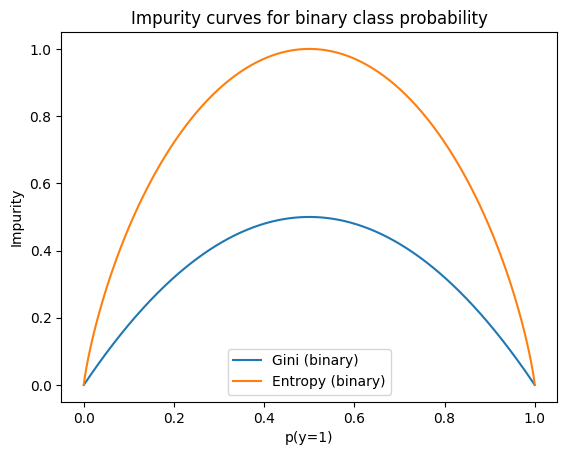

In [5]:
# Visualize impurity curves for binary classification
p = np.linspace(0.0001, 0.9999, 500)
gini_curve = 2*p*(1-p)
entropy_curve = -(p*np.log2(p) + (1-p)*np.log2(1-p))

plt.figure()
plt.plot(p, gini_curve, label="Gini (binary)")
plt.plot(p, entropy_curve, label="Entropy (binary)")
plt.xlabel("p(y=1)")
plt.ylabel("Impurity")
plt.title("Impurity curves for binary class probability")
plt.legend()
plt.show()

## 1.5 Multi-class behavior on Iris

Iris is a clean multi-class dataset. We keep regularization fixed and compare `criterion="gini"` vs `criterion="entropy"`.
We also show how to inspect the internal impurity bookkeeping stored by scikit-learn.

In [6]:
# Iris: multi-class, numeric features
iris_path = Path("../../../Datasets/Classification/iris.csv")
iris = pd.read_csv(iris_path)

X = iris.drop(columns=["classification"])
y = iris["classification"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=507, stratify=y)

clf_gini = DecisionTreeClassifier(criterion="gini", random_state=507, max_depth=4, min_samples_leaf=3)
clf_ent = DecisionTreeClassifier(criterion="entropy", random_state=507, max_depth=4, min_samples_leaf=3)

clf_gini.fit(X_train, y_train)
clf_ent.fit(X_train, y_train)

pred_gini = clf_gini.predict(X_test)
pred_ent = clf_ent.predict(X_test)

print("Accuracy (gini):", accuracy_score(y_test, pred_gini))
print("Accuracy (entropy):", accuracy_score(y_test, pred_ent))

print("\nClassification report (gini):\n", classification_report(y_test, pred_gini))
print("\nClassification report (entropy):\n", classification_report(y_test, pred_ent))

Accuracy (gini): 0.9210526315789473
Accuracy (entropy): 0.9210526315789473

Classification report (gini):
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        13
Iris-versicolor       1.00      0.75      0.86        12
 Iris-virginica       0.81      1.00      0.90        13

       accuracy                           0.92        38
      macro avg       0.94      0.92      0.92        38
   weighted avg       0.94      0.92      0.92        38


Classification report (entropy):
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        13
Iris-versicolor       1.00      0.75      0.86        12
 Iris-virginica       0.81      1.00      0.90        13

       accuracy                           0.92        38
      macro avg       0.94      0.92      0.92        38
   weighted avg       0.94      0.92      0.92        38



## 1.6 Gain ratio in action on a categorical dataset (Drug200)

We compute information gain and gain ratio for **multiway** splits on categorical features.
Note: scikit-learn's CART implementation does **binary** splits, so this part is a conceptual/diagnostic tool
and is most directly comparable to C4.5-style trees.

Focus on `row_id`: it creates many children and can have high information gain, but gain ratio should penalize it.

In [7]:
# Drug200: categorical features; show IG vs Gain Ratio and high-cardinality bias
drug_path = Path("../../../Datasets/Classification/drug200.csv")
drug = pd.read_csv(drug_path)

# Add a synthetic high-cardinality identifier
drug = drug.copy()
drug["row_id"] = np.arange(len(drug))  # almost unique

target = "Drug"
features = ["Sex", "BP", "Cholesterol", "row_id"]

def counts_for_split_categorical(df, feature, target):
    # multiway split: one child per category value
    children = []
    for val, g in df.groupby(feature):
        counts = g[target].value_counts().sort_index()
        children.append(counts.reindex(df[target].unique(), fill_value=0).values)
    parent_counts = df[target].value_counts().sort_index().reindex(df[target].unique(), fill_value=0).values
    return parent_counts, children

results = []
for f in features:
    parent_counts, children_counts = counts_for_split_categorical(drug, f, target)
    ig = info_gain(parent_counts, children_counts, impurity_fn=entropy_from_counts)
    gr = gain_ratio(parent_counts, children_counts)
    results.append((f, float(ig), float(gr), len(children_counts)))

pd.DataFrame(results, columns=["feature", "information_gain", "gain_ratio", "num_children"]).sort_values("information_gain", ascending=False)

,feature,information_gain,gain_ratio,num_children
3,row_id,1.968780,0.257564,200
1,BP,0.620127,0.393540,3
2,Cholesterol,0.093106,0.093167,2
0,Sex,0.007703,0.007712,2


## 1.7 Imbalance and weights (Diabetes)

When classes are imbalanced, a greedy criterion may focus on the majority class unless you add
constraints or weights. Here we compare a plain tree and a tree with `class_weight="balanced"`.

Look at confusion matrices: you often trade off precision vs recall for the minority class.

In [8]:
# Diabetes: class imbalance and class weights
dia_path = Path("../../../Datasets/Classification/diabetes.csv")
dia = pd.read_csv(dia_path)

X = dia.drop(columns=["classification"])
y = dia["classification"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=507, stratify=y)

tree_plain = DecisionTreeClassifier(random_state=507, max_depth=5, min_samples_leaf=10, criterion="gini")
tree_bal = DecisionTreeClassifier(random_state=507, max_depth=5, min_samples_leaf=10, criterion="gini", class_weight="balanced")

tree_plain.fit(X_train, y_train)
tree_bal.fit(X_train, y_train)

pred_plain = tree_plain.predict(X_test)
pred_bal = tree_bal.predict(X_test)

print("Plain confusion matrix:\n", confusion_matrix(y_test, pred_plain))
print("\nBalanced confusion matrix:\n", confusion_matrix(y_test, pred_bal))
print("\nPlain report:\n", classification_report(y_test, pred_plain))
print("\nBalanced report:\n", classification_report(y_test, pred_bal))

Plain confusion matrix:
 [[46 21]
 [33 92]]

Balanced confusion matrix:
 [[48 19]
 [41 84]]

Plain report:
               precision    recall  f1-score   support

    Diabetic       0.58      0.69      0.63        67
Non-Diabetic       0.81      0.74      0.77       125

    accuracy                           0.72       192
   macro avg       0.70      0.71      0.70       192
weighted avg       0.73      0.72      0.72       192


Balanced report:
               precision    recall  f1-score   support

    Diabetic       0.54      0.72      0.62        67
Non-Diabetic       0.82      0.67      0.74       125

    accuracy                           0.69       192
   macro avg       0.68      0.69      0.68       192
weighted avg       0.72      0.69      0.69       192



## 1.8 Another classification case study (Wine Quality)

We convert the numeric `quality` into a binary label (high quality vs not) and train a small entropy-based tree.
This shows how the same impurity principles apply even when the raw dataset started as a regression-style target.

Be careful: the threshold you choose to binarize affects class balance and therefore the behavior of the split criterion.

In [9]:
# Wine Quality: create a binary label and train a small tree
wine_path = Path("../../../Datasets/Classification/Wine_Quality.csv")
wine = pd.read_csv(wine_path)

# Create a binary target: high quality (>=7) vs not
wine = wine.dropna().copy()
wine["high_quality"] = (wine["quality"] >= 7).astype(int)

X = wine.drop(columns=["quality", "high_quality"])
y = wine["high_quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=507, stratify=y)

clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=25, random_state=507, criterion="entropy")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

Accuracy: 0.8163265306122449
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       960
           1       0.61      0.43      0.51       265

    accuracy                           0.82      1225
   macro avg       0.73      0.68      0.70      1225
weighted avg       0.80      0.82      0.80      1225



## 2) Regression split criteria (variance reduction)

For regression trees, we want child nodes to have targets that are as similar as possible.
CART regression typically minimizes **within-node squared error** (SSE), which is equivalent to maximizing **variance reduction**.

For a node $S$ with targets $y_1,\dots,y_n$ and mean $\bar y$:
$$
Var(S) = \frac{1}{n}\sum_{i=1}^n (y_i-\bar y)^2.
$$

A split produces children $S_1,\dots,S_m$ and the weighted variance after the split is:
$$
Var_{\text{after}} = \sum_{j=1}^m \frac{|S_j|}{|S|}Var(S_j).
$$

The variance reduction objective is:
$$
\Delta Var = Var(S) - Var_{\text{after}}.
$$

In `scikit-learn`, `DecisionTreeRegressor(criterion="squared_error")` corresponds to this idea.
You can also use `criterion="absolute_error"` (MAE) which is more robust to outliers but can be slower.

### Key practical implication
Variance reduction can strongly prefer splits that isolate small groups with very different targets. Regularization
(`min_samples_leaf`, `min_samples_split`, max depth) is the standard guardrail.

### Practical regression experiments

We run regression trees on House Prices and on a sampled Diamonds dataset. We compare:

- `criterion="squared_error"` (variance reduction / SSE)
- `criterion="absolute_error"` (MAE)

Report both RMSE and MAE so you can see how objectives trade off.

In [10]:
# Regression: House prices + Diamonds (sample if large)
hp_path = Path("../../../Datasets/Regression/house-prices.csv")
hp = pd.read_csv(hp_path)

y_hp = hp["Price"]
X_hp = hp.drop(columns=["Price"])

# Basic preprocessing: handle categorical by one-hot
X_hp = pd.get_dummies(X_hp, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_hp, y_hp, test_size=0.25, random_state=507)

reg_mse = DecisionTreeRegressor(random_state=507, max_depth=5, min_samples_leaf=5, criterion="squared_error")
reg_mae = DecisionTreeRegressor(random_state=507, max_depth=5, min_samples_leaf=5, criterion="absolute_error")

reg_mse.fit(X_train, y_train)
reg_mae.fit(X_train, y_train)

pred_mse = reg_mse.predict(X_test)
pred_mae = reg_mae.predict(X_test)

rmse_mse = rmse(y_test, pred_mse)
rmse_mae = rmse(y_test, pred_mae)
mae_mse = mean_absolute_error(y_test, pred_mse)
mae_mae = mean_absolute_error(y_test, pred_mae)

print("House prices:")
print("  squared_error  RMSE:", rmse_mse, " MAE:", mae_mse)
print("  absolute_error RMSE:", rmse_mae, " MAE:", mae_mae)

# Diamonds: may be large, so sample
dia2_path = Path("../../../Datasets/Regression/diamonds.csv")
diamonds = pd.read_csv(dia2_path)
diamonds = diamonds.sample(n=min(5000, len(diamonds)), random_state=507).copy()

y_d = diamonds["price"]
X_d = diamonds.drop(columns=["price"])

# One-hot categorical (cut, color, clarity) + keep numeric columns
X_d = pd.get_dummies(X_d, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_d, y_d, test_size=0.25, random_state=507)

reg = DecisionTreeRegressor(random_state=507, max_depth=6, min_samples_leaf=20, criterion="squared_error")
reg.fit(X_train, y_train)
pred = reg.predict(X_test)

print("\nDiamonds (sample): RMSE:", rmse(y_test, pred), " MAE:", mean_absolute_error(y_test, pred))


House prices:
  squared_error  RMSE: 14546.900834333359  MAE: 11763.258928571428
  absolute_error RMSE: 14558.964163016544  MAE: 11696.875

Diamonds (sample): RMSE: 579.097781277747  MAE: 156.7596604093391


## 3.2 Inspecting a trained tree

Trees store impurity, thresholds, and sample counts in arrays. This is extremely useful for debugging
and for verifying your manual computations.

We compute the impurity decrease of the root split and show a small visualization and a text export.

Root impurity decrease (Iris gini tree): 0.33185161564625854
Root feature index: 3 threshold: 0.800000011920929


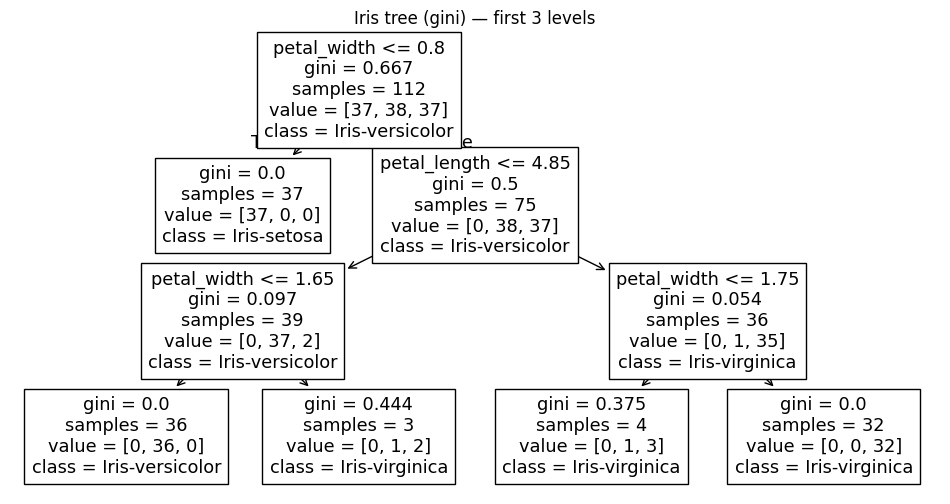


Text form:

|--- petal_width <= 0.80
|   |--- class: Iris-setosa
|--- petal_width >  0.80
|   |--- petal_length <= 4.85
|   |   |--- petal_width <= 1.65
|   |   |   |--- class: Iris-versicolor
|   |   |--- petal_width >  1.65
|   |   |   |--- class: Iris-virginica
|   |--- petal_length >  4.85
|   |   |--- petal_width <= 1.75
|   |   |   |--- class: Iris-virginica
|   |   |--- petal_width >  1.75
|   |   |   |--- class: Iris-virginica



In [11]:
# Inspect impurity and impurity decrease inside scikit-learn's trained tree
from sklearn.tree import _tree

def node_impurity_decrease(clf, node_id=0):
    tree = clf.tree_
    n = tree.n_node_samples[node_id]
    impurity_parent = tree.impurity[node_id]
    left = tree.children_left[node_id]
    right = tree.children_right[node_id]
    if left == _tree.TREE_LEAF:
        return 0.0
    nL = tree.n_node_samples[left]
    nR = tree.n_node_samples[right]
    impL = tree.impurity[left]
    impR = tree.impurity[right]
    after = (nL/n)*impL + (nR/n)*impR
    return impurity_parent - after

print("Root impurity decrease (Iris gini tree):", node_impurity_decrease(clf_gini, 0))
print("Root feature index:", clf_gini.tree_.feature[0], "threshold:", clf_gini.tree_.threshold[0])

# Use the feature names that the tree was trained on (avoid mismatch if X_train was reused later)
feature_names = list(getattr(clf_gini, "feature_names_in_", [f"X{i}" for i in range(clf_gini.n_features_in_)]))

# Visualize a small tree
plt.figure(figsize=(12, 6))
plot_tree(clf_gini, feature_names=feature_names, class_names=[str(c) for c in clf_gini.classes_], filled=False, max_depth=3)
plt.title("Iris tree (gini) — first 3 levels")
plt.show()

print("\nText form:\n")
print(export_text(clf_gini, feature_names=feature_names))

## 4) Exercises (with optional solutions)

1) **Manual impurity**: In a node with class counts $(8,2)$, compute Gini and entropy.  
2) **Threshold search**: Implement an efficient best-threshold search using sorting + prefix sums and compare runtime to a naive loop.  
3) **Gain ratio demo**: Add a synthetic high-cardinality feature (like `row_id`) to any classification dataset, compute $IG$ and $GR$, and explain the difference.  
4) **Imbalance**: On `diabetes.csv`, compare a tree with and without `class_weight="balanced"`. Look at confusion matrices.  
5) **Regression**: On `diamonds.csv`, compare `squared_error` vs `absolute_error` and report RMSE/MAE.  
6) **Tree inspection**: Use `tree_.impurity` and `tree_.n_node_samples` to compute the impurity decrease of the root split and confirm it matches your manual calculation.

### Suggested next lesson connections
- Lesson 8 (handling missing + categorical variables) extends the practical encoding and splitting details.
- Lesson 3 (pruning/overfitting) explains why split criteria alone cannot prevent deep-tree overfit.